done loading labels
Loading Image:  0
Loading Image:  100
Loading Image:  200
Loading Image:  300
Loading Image:  400
Loading Image:  500
Loading Image:  600
Loading Image:  700
Loading Image:  800
Loading Image:  900
Loading Image:  1000
Loading Image:  1100
Loading Image:  1200
Loading Image:  1300
Loading Image:  1400
Loading Image:  1500
Loading Image:  1600
Loading Image:  1700
Loading Image:  1800
Loading Image:  1900
Loading Image:  2000
Loading Image:  2100
Loading Image:  2200
Loading Image:  2300
Loading Image:  2400
Loading Image:  2500
Loading Image:  2600
Loading Image:  2700
Loading Image:  2800
Loading Image:  2900
Loading Image:  3000
Loading Image:  3100
Loading Image:  3200
Loading Image:  3300
Loading Image:  3400
Loading Image:  3500
Loading Image:  3600
Loading Image:  3700
Loading Image:  3800
Loading Image:  3900
Loading Image:  4000
Loading Image:  4100
Loading Image:  4200
Loading Image:  4300
Loading Image:  4400
Loading Image:  4500
Loading Image:  4600
Loadi

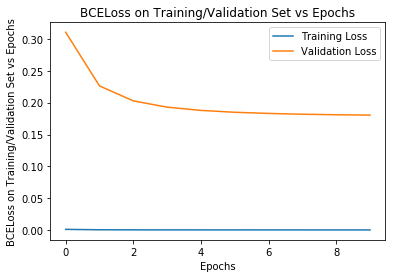

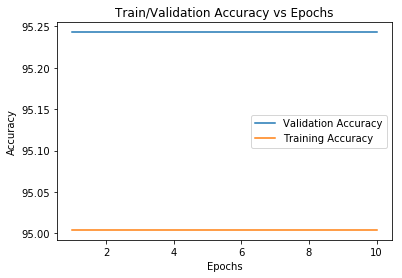

In [11]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
# coding: utf-8

# In[1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.utils.data as data_utils
import torch.nn.functional as F

import time
import os
import torch.utils.data as data_utils
import csv
from os import listdir
import numpy as np
from PIL import Image


def plot_loss_acc(list1,label1,list2,label2,title,filename):
    
    fig, ax1 = plt.subplots()
    ax1.plot(range(len(list1)), list1, 'C0', label=label1)
    ax1.plot(range(len(list2)), list2, 'C1', label = label2)
    ax1.set_xlabel('Epochs')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(title)
    ax1.tick_params('y')  
    ax1.legend(loc = 1)
    
    plt.title(title)
    plt.show()
    plt.savefig(filename)


# In[2]:


torch.cuda.is_available()


# In[3]:


original_model = models.resnet18(pretrained=True)


# In[4]:


original_model.children


# In[5]:

    
#################################NEW#############################
class CustomResnet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResnet, self).__init__()
        
        # Loading ResNet arch from PyTorch
        original_model = models.resnet18(pretrained=True)
        
        num_feats = original_model.fc.in_features
#        model.fc = nn.Linear (num_final_in, 300)        
        

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Linear(num_feats,num_classes)
        
        
        
        # Freeze all weights except the last classifier layer
        for p in self.features.parameters():
             p.requires_grad = False
        # Weights connected to classifier layer i.e. output layer        
        for p in self.fc.parameters():
            p.requires_grad = True   


#       # Init of last layer
#        for m in self.linear:
#           nn.init.kaiming_normal(m.weight)
            

    # The forward function defines the flow of the input data and 
    # thus decides which layer/chunk goes on top of what.
    def forward(self,x):
        x = torch.cat((x,x,x),1)
        x = self.features(x)
        x = torch.squeeze(x)
        x = self.fc(x)
        x = F.sigmoid(x)
        return x                                      
                                      

# In[6]:


# load custom model
amine_resnet = CustomResnet(num_classes=14)
params = list(amine_resnet.fc.parameters())
optimizer = torch.optim.SGD(params=params, lr=0.01)
criterion = nn.BCELoss()
amine_resnet.cuda()


# In[7]:


#Ultra Parameters
num_images = 5000
shuffle = True
random_seed = 58
valid_size = 0.2

#Hyper Parameters
num_epochs = 10
batch_size = 250

'''
This function takes in an image's path and returns 
a numpy array that contains all its pixel values.
The dimension of the output array is (channels, width, height).
And in our case, channels = 1.
'''
def get_image(image_path):
    image = Image.open(image_path, 'r')
#    width, height = image.size[0]/4, image.size[1]/4
#    image.thumbnail((width,height),Image.ANTIALIAS)
    width, height = image.size[0], image.size[1]
#    if image.mode != 'L':
#        image = image.convert('L')
    pixel_values = list(image.getdata())
    #pixel_values = np.array(pixel_values).reshape((width, height))
    #pixel_values = preprocessing.scale(pixel_values)
    pixel_values = np.array(pixel_values).reshape((1, width, height))
    #pixel_values = np.array(pixel_values)
    return pixel_values

'''
Just loop through all the images in the image folder
and call convert each of them to an array.
The dimension of output is (num of images, (channels, width, height))
'''

#new loadImages function
def loadImages(directory,num_images):
    imageList = listdir(directory)
    loadedImages = []
    index = 0
    for image in imageList:
        if index == num_images: break
        pixel_values = torch.load(directory + image)
        loadedImages.append(pixel_values)
        if index % 100 == 0:
            print "Loading Image: ", index
        index += 1
	#print index
    return loadedImages

'''
Function name explains itself
'''
def constructLabelByString(labelStr):
    label_vector = [0] * 14
    if labelStr == 'No Finding':
        return label_vector

    symptom_vector = ['Atelectasis', 'Cardiomegaly', 'Effusion',     'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',     'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',     'Pleural_Thickening', 'Hernia']
    
    symptoms = labelStr.split('|')
    for s in symptoms:
        label_vector[symptom_vector.index(s)] = 1
    return label_vector
   
'''
Generate labels
'''
def parseDataEntry(dataEntryPath):   
    #Each element in the map is a tuple (image filename, corresponding label)
    labels = []
    index = 0
    with open('/datasets/ChestXray-NIHCC/Data_Entry_2017.csv', 'rb') as file:
        reader = csv.reader(file)
        for row in reader:
            if index == 0: 
                index += 1
                continue
            label_vector = constructLabelByString(row[1])
            labels.append(label_vector)
    return labels
            
#Image Path
#image_dir = '/datasets/tmp/tum/'
#these are tensor floats already
image_dir = '/datasets/tmp/tum_torch/001/'
data_entry_path = '/datasets/ChestXray-NIHCC/Data_Entry_2017.csv'


#Get labels
loadedLabels = np.array(parseDataEntry(data_entry_path)[:num_images])
print "done loading labels"
#Load Images new method
loadedImages = torch.stack(loadImages(image_dir,num_images))
print "done loading images"


#new loading 
features = loadedImages.float()
targets = torch.from_numpy(loadedLabels).float()
train_dataset = data_utils.TensorDataset(features, targets)
valid_dataset = data_utils.TensorDataset(features, targets)

#Using SubsetRandomSampler for 1-fold cross validation

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size*num_train))
if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = data_utils.sampler.SubsetRandomSampler(train_idx)
test_sampler = data_utils.sampler.SubsetRandomSampler(indices[split+200:split+699])
valid_sampler = data_utils.sampler.SubsetRandomSampler(valid_idx)

train_loader = data_utils.DataLoader(train_dataset, batch_size = batch_size,                                      sampler = train_sampler, pin_memory = True)
test_loader = data_utils.DataLoader(train_dataset, batch_size = 1, sampler = test_sampler, pin_memory = True)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size = 1,                                      sampler = valid_sampler, pin_memory = True)

def validation(loader, criterion):
        lossList = []
        # Test the Model
        amine_resnet.eval()  
        correct_naive = 0
        correct_tolerance = 0
        correct_absolute = 0
        total = 0
        for images, labels in valid_loader:
            images = Variable(images).cuda()
	    lll = Variable(labels).cuda()
            outputs = amine_resnet(images)
            loss = criterion(outputs, lll)
            lossList.append(loss.data[0])
            prediction = outputs.data.cpu().numpy()
            prediction[prediction >= 0.6] = 1
            prediction[prediction < 0.6] = 0
            total += labels.size(0)
            labels = labels.numpy()
            diff = np.count_nonzero(prediction != labels)
            correct_rate = 1.0 - (float(diff) / 14.0)
        return (sum(lossList) / len(lossList))


trainingLossList = []
validationLossList = []
trainingAccList = []
validationAccList = []

# In[9]:
for epoch in range(num_epochs):
    epochLoss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = amine_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss += loss.data[0]
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
        %(epoch+1, num_epochs, i+1, np.floor(len(train_dataset)*(1-valid_size))//batch_size, loss.data[0]))
    trainingLossList.append(epochLoss / (len(train_dataset)/batch_size)/batch_size)
    validationLossList.append(validation(valid_loader, criterion))
    print len(validationLossList)
    print len(trainingLossList)
    
    amine_resnet.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = Variable(images).cuda()
        outputs = amine_resnet(images)
        prediction = outputs.data.cpu().numpy()
        prediction[prediction >= 0.6] = 1
        prediction[prediction < 0.6] = 0
        total += labels.size(0)
        labels = labels.numpy()
        #print ("labels = ", labels)
        #print ("prediction = ", prediction)
        #print np.array_equal(prediction, labels)
        #raw_input()
        diff = np.count_nonzero(prediction != labels)
        correct_rate = 1.0 - (float(diff) / 14.0)
        correct+= correct_rate
    validationAccList.append(100*correct/total)
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images).cuda()
        outputs = amine_resnet(images)
        prediction = outputs.data.cpu().numpy()
        prediction[prediction >= 0.6] = 1
        prediction[prediction < 0.6] = 0
        total += labels.size(0)
        labels = labels.numpy()
        #print ("labels = ", labels)
        #print ("prediction = ", prediction)
        #print np.array_equal(prediction, labels)
        #raw_input()
        diff = np.count_nonzero(prediction != labels)
        correct_rate = 1.0 - (float(diff) / 14.0)
        correct+= correct_rate
    trainingAccList.append(100*correct/total)
    amine_resnet.train()
plot_loss_acc(trainingLossList, 'Training Loss', validationLossList, 'Validation Loss', 'BCELoss on Training/Validation Set vs Epochs', 'resnet_lossplot.png')
# In[10]:


# Test the Model


plt.plot(range(1,num_epochs+1),validationAccList,label = 'Validation Accuracy')
plt.plot(range(1,num_epochs+1),trainingAccList,label = 'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train/Validation Accuracy vs Epochs')
plt.show()    
    
#print('Test Accuracy of the model: %d %% (Total: %d; Correct: %d)' % (100 * correct / total, total, correct))

[95.23332379043804, 95.23332379043805, 95.23332379043799, 95.23332379043799, 95.23332379043802, 95.23332379043798, 95.23332379043802, 95.233323790438, 95.23332379043802, 95.233323790438]
